In [44]:
%reload_ext autoreload
%autoreload 2

### 1. Split data into train, test

In [45]:
from datasets.german_credit import GermanCreditDataset
dataset = GermanCreditDataset()
X_train, y_train, X_test, _ = dataset.get_original_train_test_split()

[INFO] Dropped rows with NaN: 478 (kept 522)


Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


### 2. Build the preprocessor

In [46]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd
from sklearn.pipeline import Pipeline

# Define feature lists
numerical_features = ['Age', 'Credit amount', 'Duration']
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

# Build the preprocessor — use OrdinalEncoder
cat_pipe = Pipeline(steps=[
    ('ord', OrdinalEncoder(
        handle_unknown='use_encoded_value',
        unknown_value=-1,      # unseen categories are encoded as -1 (usually not present during fit)
        # Optional: if you want to explicitly specify the order (recommended), list from low to high
        # categories=[ ['primary', 'secondary', 'bachelor', 'master', 'phd'], ... ]
    )),
    ('sc', StandardScaler())    # standardize the ordinal-encoded outputs
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', cat_pipe, categorical_features),
    ],
    remainder='passthrough'
)

preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num', StandardScaler(),
                                 ['Age', 'Credit amount', 'Duration']),
                                ('cat',
                                 Pipeline(steps=[('ord',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1)),
                                                 ('sc', StandardScaler())]),
                                 ['Sex', 'Job', 'Housing', 'Saving accounts',
                                  'Checking account', 'Purpose'])])

### 3. Train the model (Built-in DNN)

In [ ]:
from xai_cola.ce_sparsifier.utils.pytorch_models import DNN, LinearSVM
import torch
import torch.nn as nn
import torch.optim as optim

# 1. Prepare data — input_dim is inferred from the processed data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed  = preprocessor.transform(X_test)
input_dim = X_train_processed.shape[1]  # dynamically obtain feature dimension

X_train = torch.FloatTensor(X_train_processed)               # shape: [n_samples, n_features]
y_train = torch.FloatTensor(y_train.values).unsqueeze(1)     # shape: [n_samples, 1]

# 2. Create model
model1 = DNN(input_dim=input_dim, hidden_dim=30)  # input_dim = number of features
# model2 = LinearSVM(input_dim=input_dim)

# 3. Train
criterion = nn.BCELoss()
optimizer = optim.Adam(model1.parameters(), lr=0.01)

for epoch in range(100):
    outputs = model1(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


### 3. Pick instances(whose predictions are 1)

In [50]:
import pandas as pd

# === Config ===
TARGET_COLUMN_NAME = "Risk"   # name of the prediction column
N = 10                        # number of rows to sample; set to None to return all
RANDOM_STATE = 42

# 1) Predict
X_df = X_test.copy() if isinstance(X_test, pd.DataFrame) else pd.DataFrame(X_test)
X_transformed = preprocessor.transform(X_df)
preds = pd.Series(model1.predict(X_transformed), index=X_df.index, name=TARGET_COLUMN_NAME).astype(int)


# 2) Overwrite instead of append (avoid duplicate columns)
X_df = X_df.drop(columns=[TARGET_COLUMN_NAME], errors="ignore")
X_df[TARGET_COLUMN_NAME] = preds.values
X_test = X_df  # overwrite the variable

# 3) Select rows predicted as 1 and optionally sample
df = X_test.loc[X_test[TARGET_COLUMN_NAME] == 1]
if N is not None and len(df) > N:
    df = df.sample(n=N, random_state=RANDOM_STATE)

# Optional: inspect
# display(X_test.head())
df.head()


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
176,24,female,highly skilled,own,moderate,moderate,7408,60,car,1
57,24,male,skilled,rent,little,moderate,2323,36,radio/TV,1
505,22,male,skilled,own,moderate,moderate,1514,15,repairs,1
58,35,male,skilled,rent,little,moderate,1919,9,furniture/equipment,1
485,23,female,skilled,own,little,little,1498,12,radio/TV,1


---------------------------

### **1**. Initialize data interface (COLAData)

In [51]:
from xai_cola.ce_sparsifier.data import COLAData

numerical_features = ['Age', 'Credit amount', 'Duration']
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
data = COLAData(
    factual_data=df, 
    label_column='Risk',
    numerical_features=numerical_features,
    transform_method=preprocessor,
)
print(data)

COLAData(factual: 10 rows, features: 9, label: Risk, no counterfactual)


### **2**. Initialize model interface (Model)

In [52]:
from xai_cola.ce_sparsifier.models import Model

ml_model = Model(model=model1, backend="pytorch")

### **3.** Choose the counterfactual generator & generate counterfactuals

In [53]:
from xai_cola.ce_generator import DiCE, DisCount

explainer = DisCount(ml_model=ml_model)
factual, counterfactual = explainer.generate_counterfactuals(
    data=data,
    factual_class=1,  # class label of the factual instances (target column)
    # explain_columns=[
    #     'Housing','Saving accounts','Checking account',
    #     'Credit amount','Duration'
    # ],
    max_iter=200,     # Max iteration steps (can add early stopping)
    silent=True,     # whether to print logs during optimization
)
display(counterfactual)


# Add counterfactual data to COLAData object first
data.add_counterfactuals(counterfactual, with_target_column=True)
data.summary()

INFO:root:Optimization started
 96%|█████████▌| 192/200 [03:50<00:09,  1.20s/it]


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
176,23,female,highly skilled,own,moderate,moderate,7388,60,car,1
57,23,male,skilled,rent,little,moderate,3024,35,radio/TV,0
505,22,male,skilled,own,moderate,moderate,3034,10,repairs,0
58,31,male,skilled,rent,little,moderate,2740,8,furniture/equipment,0
485,24,female,skilled,own,little,little,1831,10,radio/TV,0
403,35,male,skilled,own,little,little,393,9,car,0
342,37,male,skilled,free,little,rich,1264,23,car,0
314,32,female,unskilled and resident,own,moderate,moderate,1851,4,car,0
369,47,female,skilled,free,moderate,rich,1387,24,radio/TV,1
138,28,female,skilled,own,little,moderate,2519,30,car,0


{'factual_samples': 10,
 'feature_count': 9,
 'label_column': 'Risk',
 'all_columns': ['Age',
  'Sex',
  'Job',
  'Housing',
  'Saving accounts',
  'Checking account',
  'Credit amount',
  'Duration',
  'Purpose',
  'Risk'],
 'has_counterfactual': True,
 'has_transform_method': True,
 'has_transformed_data': True,
 'counterfactual_samples': 10,
 'transformed_feature_columns': ['Age',
  'Credit amount',
  'Duration',
  'Sex',
  'Job',
  'Housing',
  'Saving accounts',
  'Checking account',
  'Purpose'],
 'has_transformed_counterfactual': True}

### **4.** Initialize COLA & set policy

In [64]:
from xai_cola.ce_sparsifier import COLA

# Initialize COLA - it will automatically extract factual and counterfactual from data
sparsifier = COLA(
    data=data,
    ml_model=ml_model
)

sparsifier.set_policy(
    matcher="nn", # optimal transport matcher
    attributor="pshap", # SHAP attributor
    random_state=1 # Set random seed for reproducibility
)

Using transformed data from COLAData (transform_method: ColumnTransformer)
Policy set: pshap with Nearest Neighbor Matching.


### **5.** Refine counterfactuals with COLA

In [70]:
# Query minimum actions
limited_actions = sparsifier.query_minimum_actions()

The minimum number of actions is 10


In [71]:
# Get (refined counterfactuals) with limited actions
refined_cf_df = sparsifier.get_refined_counterfactual(limited_actions=limited_actions)
display(refined_cf_df)

# Get (factual, counterfactual, refined counterfactuals) with limited actions
# factual_df, counterfactual_df, refined_cf_df = sparsifier.get_all_results(
#     limited_actions=limited_actions,
#     # features_to_vary=['Saving accounts','Checking account','Credit amount','Duration','Purpose']
# )
# display(counterfactual_df,refined_cf_df)

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.00023249 0.00010511]


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.01931677 0.46078081 0.02076419]


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.60425384 0.26973672]


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.48214999 0.37770492 0.01569056]


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.09670325 0.12989673 0.2297578 ]


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.04607826 0.44359838]


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.02112212 0.04613011 0.02202528]


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.88193876 0.06513404]


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

INFO:shap:num_full_subsets = 1
INFO:shap:phi = [0.20608738 0.03193852]



[DEBUG] Predictions on transformed factual: [1 1 1 1 1 1 1 1 1 1]

[DEBUG] Predictions on transformed counterfactual: [1 0 0 0 0 0 1 0 1 1]
[DEBUG] Predictions on x_action_constrained (before inverse_transform): [1 0 0 0 0 0 1 0 1 1]
[DEBUG] Predictions on corresponding_counterfactual (q): [1 0 0 0 0 0 1 0 1 1]


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
176,24,female,highly skilled,own,moderate,moderate,7408,60,car,1
57,23,male,skilled,rent,little,moderate,3024,36,radio/TV,0
505,22,male,skilled,own,moderate,moderate,3034,10,repairs,0
58,31,male,skilled,rent,little,moderate,2740,9,furniture/equipment,0
485,23,female,skilled,own,little,little,1831,12,radio/TV,0
403,35,male,skilled,own,little,little,691,9,car,0
342,38,male,skilled,free,little,rich,1264,24,car,1
314,32,female,unskilled and resident,own,moderate,moderate,1851,6,car,0
369,47,female,skilled,free,moderate,rich,1377,24,radio/TV,1
138,24,female,skilled,own,little,moderate,2150,30,car,1


#### **6.** Visualization

##### 6.1 Highlight the changes between factual and counterfactual

In [72]:
factual, ce, refine_ce = sparsifier.highlight_changes_comparison()
display(factual, ce, refine_ce) # display the highlighted dataframes
# refine_ce.to_html('comparison.html')  # save to html file

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
176,24,female,highly skilled,own,moderate,moderate,7408,60,car,1
57,24,male,skilled,rent,little,moderate,2323,36,radio/TV,1
505,22,male,skilled,own,moderate,moderate,1514,15,repairs,1
58,35,male,skilled,rent,little,moderate,1919,9,furniture/equipment,1
485,23,female,skilled,own,little,little,1498,12,radio/TV,1
403,35,male,skilled,own,little,little,691,12,car,1
342,38,male,skilled,free,little,rich,947,24,car,1
314,32,female,unskilled and resident,own,moderate,moderate,931,6,car,1
369,47,female,skilled,free,moderate,rich,1377,24,radio/TV,1
138,24,female,skilled,own,little,moderate,2150,30,car,1


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
176,24 -> 23,female,highly skilled,own,moderate,moderate,7408 -> 7388,60,car,1
57,24 -> 23,male,skilled,rent,little,moderate,2323 -> 3024,36 -> 35,radio/TV,1 -> 0
505,22,male,skilled,own,moderate,moderate,1514 -> 3034,15 -> 10,repairs,1 -> 0
58,35 -> 31,male,skilled,rent,little,moderate,1919 -> 2740,9 -> 8,furniture/equipment,1 -> 0
485,23 -> 24,female,skilled,own,little,little,1498 -> 1831,12 -> 10,radio/TV,1 -> 0
403,35,male,skilled,own,little,little,691 -> 393,12 -> 9,car,1 -> 0
342,38 -> 37,male,skilled,free,little,rich,947 -> 1264,24 -> 23,car,1
314,32,female,unskilled and resident,own,moderate,moderate,931 -> 1851,6 -> 4,car,1 -> 0
369,47,female,skilled,free,moderate,rich,1377 -> 1387,24,radio/TV,1
138,24 -> 28,female,skilled,own,little,moderate,2150 -> 2519,30,car,1


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
176,24,female,highly skilled,own,moderate,moderate,7408,60,car,1
57,24 -> 23,male,skilled,rent,little,moderate,2323 -> 3024,36,radio/TV,1 -> 0
505,22,male,skilled,own,moderate,moderate,1514 -> 3034,15 -> 10,repairs,1 -> 0
58,35 -> 31,male,skilled,rent,little,moderate,1919 -> 2740,9,furniture/equipment,1 -> 0
485,23,female,skilled,own,little,little,1498 -> 1831,12,radio/TV,1 -> 0
403,35,male,skilled,own,little,little,691,12 -> 9,car,1 -> 0
342,38,male,skilled,free,little,rich,947 -> 1264,24,car,1
314,32,female,unskilled and resident,own,moderate,moderate,931 -> 1851,6,car,1 -> 0
369,47,female,skilled,free,moderate,rich,1377,24,radio/TV,1
138,24,female,skilled,own,little,moderate,2150,30,car,1


##### 6.2 Highlight the changed positions in counterfactuals and refined counterfactuals

In [73]:
factual_df, ce_style, ace_style = sparsifier.highlight_changes_final()
display(ce_style, ace_style)  # display the highlighted dataframes
# ce_style.to_html('final.html') # save to html file

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
176,23,female,highly skilled,own,moderate,moderate,7388,60,car,1
57,23,male,skilled,rent,little,moderate,3024,35,radio/TV,0
505,22,male,skilled,own,moderate,moderate,3034,10,repairs,0
58,31,male,skilled,rent,little,moderate,2740,8,furniture/equipment,0
485,24,female,skilled,own,little,little,1831,10,radio/TV,0
403,35,male,skilled,own,little,little,393,9,car,0
342,37,male,skilled,free,little,rich,1264,23,car,1
314,32,female,unskilled and resident,own,moderate,moderate,1851,4,car,0
369,47,female,skilled,free,moderate,rich,1387,24,radio/TV,1
138,28,female,skilled,own,little,moderate,2519,30,car,1


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
176,24,female,highly skilled,own,moderate,moderate,7408,60,car,1
57,23,male,skilled,rent,little,moderate,3024,36,radio/TV,0
505,22,male,skilled,own,moderate,moderate,3034,10,repairs,0
58,31,male,skilled,rent,little,moderate,2740,9,furniture/equipment,0
485,23,female,skilled,own,little,little,1831,12,radio/TV,0
403,35,male,skilled,own,little,little,691,9,car,0
342,38,male,skilled,free,little,rich,1264,24,car,1
314,32,female,unskilled and resident,own,moderate,moderate,1851,6,car,0
369,47,female,skilled,free,moderate,rich,1377,24,radio/TV,1
138,24,female,skilled,own,little,moderate,2150,30,car,1


##### 6.3 Heatmap of Changes: Factuals vs. Counterfactuals / Refined Counterfactuals

In [74]:
sparsifier.heatmap_binary(save_path='./results', save_mode='combined',show_axis_labels=False)


Binary changes from factual to counterfactual:
Binary changes from factual to action-limited counterfactual:
✅ Combined heatmap saved to: ./results\combined_heatmap.png


(<Figure size 1000x600 with 1 Axes>, <Figure size 1000x600 with 1 Axes>)

##### 6.4 Heatmap of Change Direction(increase or decrease): Factuals vs. Counterfactuals / Refined Counterfactuals

In [75]:
sparsifier.heatmap_direction(save_path='./results', save_mode='combined',show_axis_labels=False)

Directional changes from factual to counterfactual:
Directional changes from factual to action-limited counterfactual:


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


✅ Combined directional heatmap saved to: ./results\combined_direction_heatmap.png


(<Figure size 1000x600 with 1 Axes>, <Figure size 1000x600 with 1 Axes>)

##### 6.5 Actions Required to Flip the Target per Instance: Refined Counterfactuals vs. Original Counterfactuals

✅ Stacked bar chart saved to: ./results\stacked_bar_chart.png


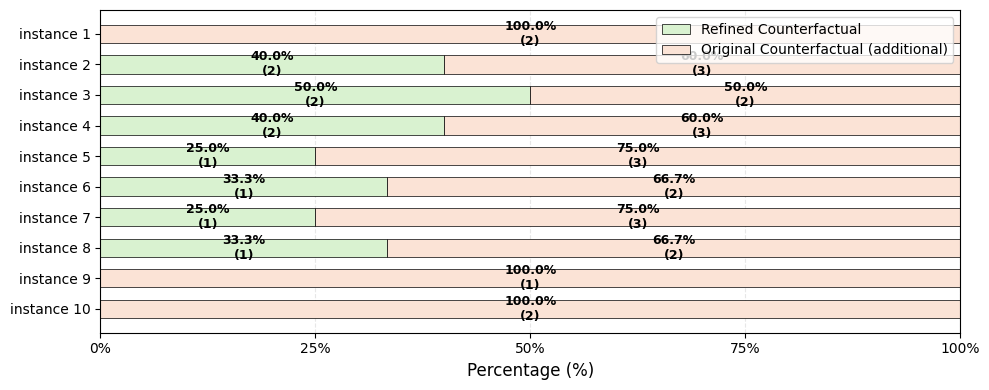

In [76]:
fig = sparsifier.stacked_bar_chart(save_path='./results')

##### 6.6 Diversity results via exhaustive search on refined counterfactuals

In [78]:
factual_df, diversity_styles = sparsifier.diversity()
for i, style in enumerate(diversity_styles):
    print(f"Instance {i+1} diversity:")
    display(style)

Instance 1 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,24,female,highly skilled,own,moderate,moderate,7408,60,car,1


Instance 2 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,23,male,skilled,rent,little,moderate,3024,36,radio/TV,0
1,24,male,skilled,rent,little,moderate,3024,36,radio/TV,0


Instance 3 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,22,male,skilled,own,moderate,moderate,3034,10,repairs,0


Instance 4 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,31,male,skilled,rent,little,moderate,2740,9,furniture/equipment,0
1,31,male,skilled,rent,little,moderate,1919,9,furniture/equipment,0


Instance 5 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,23,female,skilled,own,little,little,1831,12,radio/TV,0


Instance 6 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,35,male,skilled,own,little,little,691,9,car,0


Instance 7 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,38,male,skilled,free,little,rich,1264,24,car,1


Instance 8 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,32,female,unskilled and resident,own,moderate,moderate,1851,6,car,0


Instance 9 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,47,female,skilled,free,moderate,rich,1377,24,radio/TV,1


Instance 10 diversity:


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,24,female,skilled,own,little,moderate,2150,30,car,1
